### -- Import required packages

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
import datetime as dt

In [8]:
import warnings
warnings.filterwarnings("ignore")

###  -- Retrieve raw data

In [9]:
# Charger le fichier CSV
file_path = 'World-Stock-Prices-Dataset.csv'
data = pd.read_csv(file_path)


In [10]:
print("\n**************** data overview ******** \n")
print(data.info())



**************** data overview ******** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 279753 entries, 0 to 279752
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          279753 non-null  object 
 1   Open          279753 non-null  float64
 2   High          279753 non-null  float64
 3   Low           279753 non-null  float64
 4   Close         279753 non-null  float64
 5   Volume        279753 non-null  float64
 6   Dividends     279753 non-null  float64
 7   Stock Splits  279753 non-null  float64
 8   Brand_Name    279753 non-null  object 
 9   Ticker        279753 non-null  object 
 10  Industry_Tag  279753 non-null  object 
 11  Country       279753 non-null  object 
dtypes: float64(7), object(5)
memory usage: 25.6+ MB
None


### -- Preprocessing data

In [11]:
# Filtrer les données pour ne garder que celles d'Apple
apple_df = data[data['Brand_Name'] == 'apple']

# Sélectionner uniquement la colonne 'Close' et convertir la colonne 'Date'
apple_close_df = apple_df[['Date', 'Close']]


In [12]:
apple_close = apple_close_df.copy()

# Assurez que la colonne de dates est au format datetime
apple_close['Date'] = pd.to_datetime(apple_close['Date'].str.split(" ").str[0])

# Trier le DataFrame 'apple_close' par la colonne 'Date'
apple_close = apple_close.sort_values('Date')

# Ajouter une nouvelle colonne avec les noms des jours de la semaine
apple_close['Day_Name'] = apple_close['Date'].dt.day_name()


In [13]:
print("\n**************** data overview ******** \n")
print(apple_close.info())



**************** data overview ******** 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5969 entries, 19031 to 4
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      5969 non-null   datetime64[ns]
 1   Close     5969 non-null   float64       
 2   Day_Name  5969 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 186.5+ KB
None


In [14]:
apple_close.set_index('Date', inplace=True)

print("\n************ data overview ****** \n")
print(apple_close)


************ data overview ****** 

                 Close   Day_Name
Date                             
2000-01-03    0.848323     Monday
2000-01-04    0.776801    Tuesday
2000-01-05    0.788168  Wednesday
2000-01-06    0.719961   Thursday
2000-01-07    0.754065     Friday
...                ...        ...
2023-09-15  175.009995     Friday
2023-09-15  175.009995     Friday
2023-09-18  177.970001     Monday
2023-09-19  179.070007    Tuesday
2023-09-20  175.490005  Wednesday

[5969 rows x 2 columns]


In [15]:
# Vérifier et gérer les doublons (garder la première occurrence)
apple_close = apple_close[~apple_close.index.duplicated(keep='first')]

In [16]:
# Créer un index complet de dates
start_date = apple_close.index.min()
end_date = apple_close.index.max()
full_index = pd.date_range(start=start_date, end=end_date, freq='D')  # 'D' pour quotidien

# Réindexer le DataFrame original avec l'index complet
apple_close = apple_close.reindex(full_index)

# Update Day_name column to fill gaps
apple_close['Day_Name'] = apple_close.index.day_name()

In [17]:
print("\n************ data overview ****** \n")
print(apple_close)


************ data overview ****** 

                 Close   Day_Name
2000-01-03    0.848323     Monday
2000-01-04    0.776801    Tuesday
2000-01-05    0.788168  Wednesday
2000-01-06    0.719961   Thursday
2000-01-07    0.754065     Friday
...                ...        ...
2023-09-16         NaN   Saturday
2023-09-17         NaN     Sunday
2023-09-18  177.970001     Monday
2023-09-19  179.070007    Tuesday
2023-09-20  175.490005  Wednesday

[8662 rows x 2 columns]


In [18]:
# Appliquer fill forward pour remplir les lacunes
apple_close.fillna(method='ffill', inplace=True)

print("\n************* data overview ****** \n")
print(apple_close)


************* data overview ****** 

                 Close   Day_Name
2000-01-03    0.848323     Monday
2000-01-04    0.776801    Tuesday
2000-01-05    0.788168  Wednesday
2000-01-06    0.719961   Thursday
2000-01-07    0.754065     Friday
...                ...        ...
2023-09-16  175.009995   Saturday
2023-09-17  175.009995     Sunday
2023-09-18  177.970001     Monday
2023-09-19  179.070007    Tuesday
2023-09-20  175.490005  Wednesday

[8662 rows x 2 columns]


In [19]:
apple_close.drop('Day_Name', axis=1, inplace=True)

In [20]:
apple_close = apple_close[apple_close.index >= "2018-09-20"]

In [21]:
apple_close.index


DatetimeIndex(['2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23',
               '2018-09-24', '2018-09-25', '2018-09-26', '2018-09-27',
               '2018-09-28', '2018-09-29',
               ...
               '2023-09-11', '2023-09-12', '2023-09-13', '2023-09-14',
               '2023-09-15', '2023-09-16', '2023-09-17', '2023-09-18',
               '2023-09-19', '2023-09-20'],
              dtype='datetime64[ns]', length=1827, freq='D')

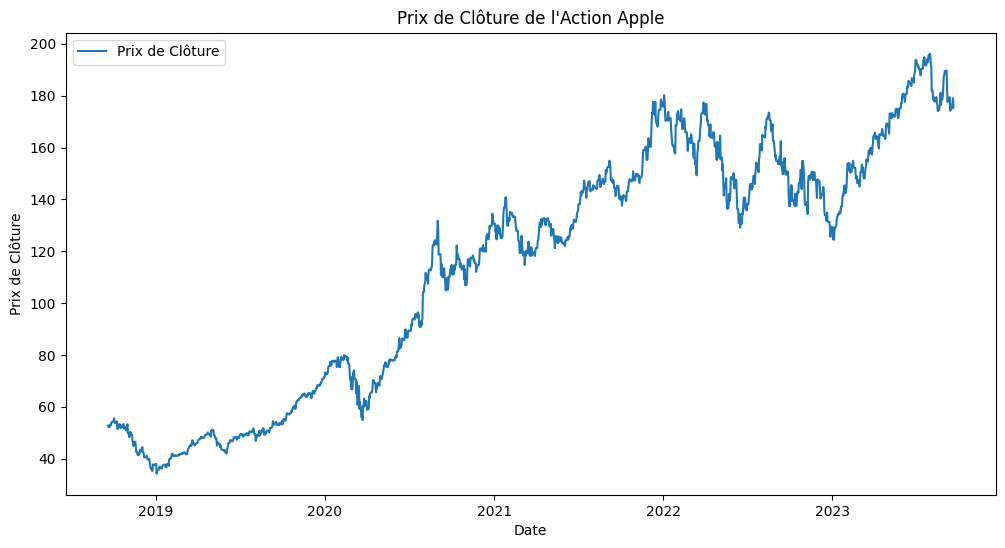

In [22]:
# Visualisation des données après la gestion des doublons et des valeurs manquantes
plt.figure(figsize=(12, 6))
plt.plot(apple_close, label='Prix de Clôture')
plt.title('Prix de Clôture de l\'Action Apple')
plt.xlabel('Date')
plt.ylabel('Prix de Clôture')
plt.legend()
plt.show()

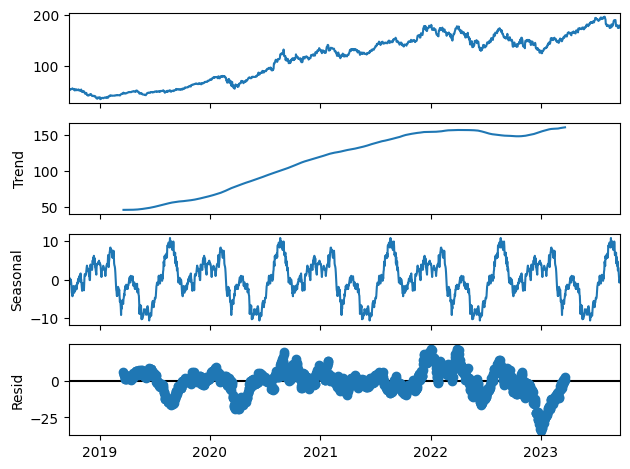

In [23]:
# Décomposition saisonnière pour observer le trend et la saisonnalité
decomposition = sm.tsa.seasonal_decompose(apple_close, model='additive', period=365)
fig = decomposition.plot()
plt.show()

In [24]:
# Test ADF
adf_test = adfuller(apple_close['Close'])
adf_output = pd.Series(adf_test[0:4], index=['Test Statistic', 'p_value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test[4].items():
    adf_output['Critical Value (%s)' % key] = value

# Afficher les résultats du test ADF
print(adf_output)
# Displaying if the series is stationary or not
p_value = adf_test[1]
if p_value <0.05:
    print("\n===> The original time serie is stationary.")
else:
    print("\n===> The original time serie is not stationary .")

Test Statistic                   -0.870030
p_value                           0.797682
#Lags Used                       20.000000
Number of Observations Used    1806.000000
Critical Value (1%)              -3.433976
Critical Value (5%)              -2.863142
Critical Value (10%)             -2.567623
dtype: float64

===> The original time serie is not stationary .


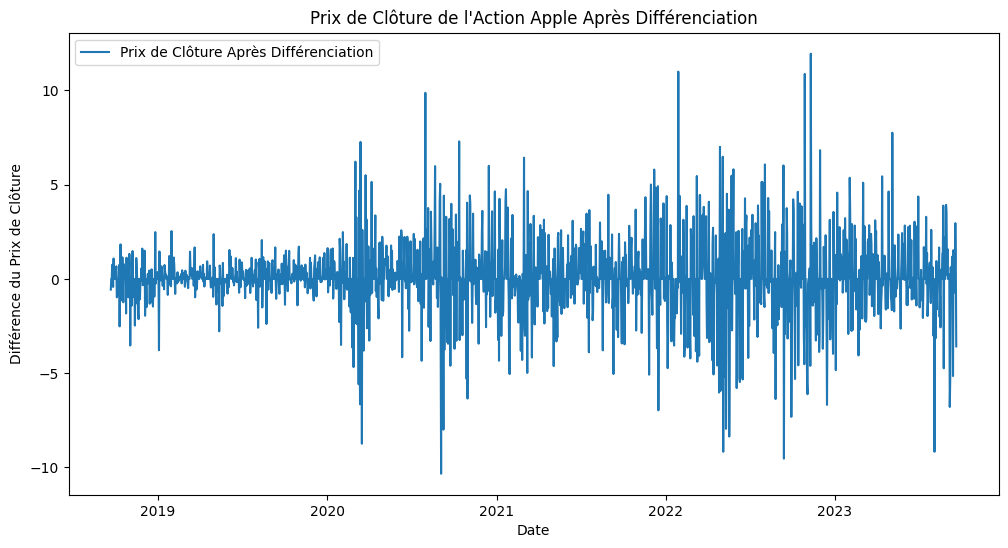

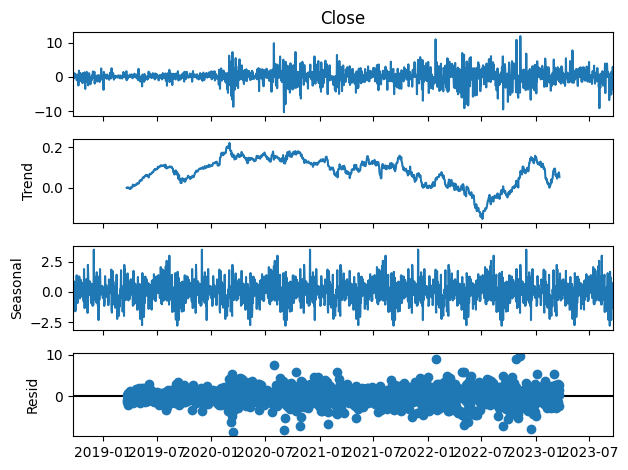

########################################### The time serie is stationary after 1_differenciation ###########################################.


In [25]:
# Appliquer la différenciation
apple_diff = apple_close['Close'].diff().dropna()

# Visualisation des données différenciées
plt.figure(figsize=(12, 6))
plt.plot(apple_diff, label='Prix de Clôture Après Différenciation')
plt.title('Prix de Clôture de l\'Action Apple Après Différenciation')
plt.xlabel('Date')
plt.ylabel('Différence du Prix de Clôture')
plt.legend()
plt.show()

# Décomposition saisonnière des données différenciées
decomposition_diff = sm.tsa.seasonal_decompose(apple_diff, model='additive', period=365)
fig_diff = decomposition_diff.plot()
plt.show()

# Test ADF sur les données différenciées
adf_test_diff = adfuller(apple_diff)
adf_output_diff = pd.Series(adf_test_diff[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_output_diff['Critical Value (%s)' % key] = value

# Afficher les résultats du test ADF sur les données différenciées
adf_output_diff
# Displaying if the series is stationary or not
p_value = adf_output_diff[1]
if p_value <0.05:
    print("########################################### The time serie is stationary after 1_differenciation ###########################################.")
else:
    print("########################################### The time serie still not stationary even after 1_differenciation  ###########################################.")

## Ajustement du modèle

In [26]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools

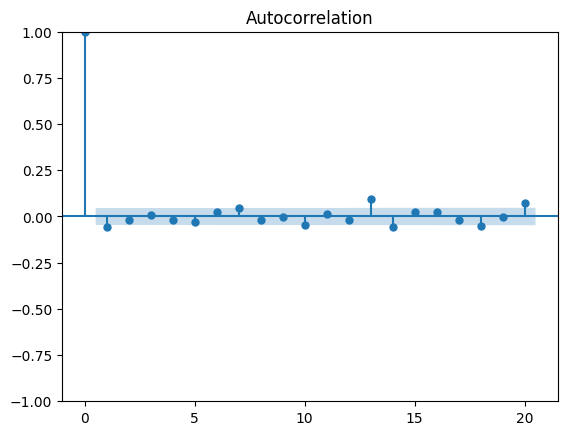

In [27]:
# Plot ACF
plot_acf(apple_diff, lags=20)
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1826
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -3805.830
Date:                Sat, 25 Nov 2023   AIC                           7617.659
Time:                        00:47:38   BIC                           7634.189
Sample:                    09-21-2018   HQIC                          7623.756
                         - 09-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0674      0.043      1.565      0.118      -0.017       0.152
ma.L1         -0.0565      0.017     -3.368      0.001      -0.089      -0.024
sigma2         3.7833      0.067     56.714      0.0

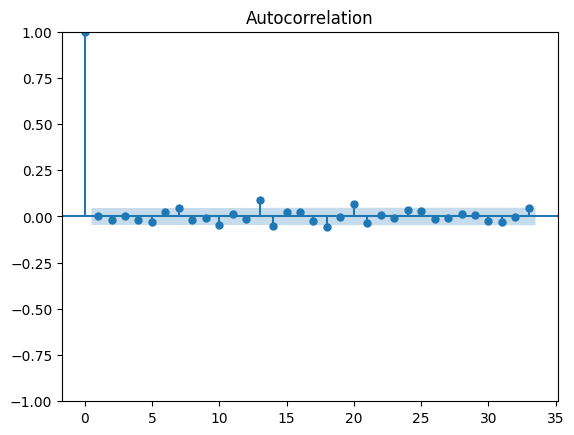

In [28]:
# Ajuster le modèle MA en utilisant un ordre choisi basé sur l'ACF
q=1
model_ma = ARIMA(apple_diff, order=(0, 0, q))
results_ma = model_ma.fit()

# Afficher le résumé du modèle
print(results_ma.summary())

# Vérifier les résidus
residus = results_ma.resid
plot_acf(residus)
plt.show()

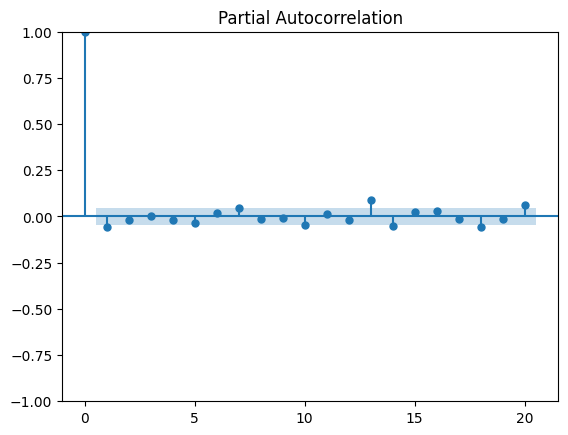

In [29]:
# Plot PACF pour déterminer l'ordre
plot_pacf(apple_diff, lags=20)
plt.show()


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1826
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -3805.937
Date:                Sat, 25 Nov 2023   AIC                           7617.875
Time:                        00:47:41   BIC                           7634.404
Sample:                    09-21-2018   HQIC                          7623.972
                         - 09-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0673      0.043      1.557      0.119      -0.017       0.152
ar.L1         -0.0544      0.017     -3.248      0.001      -0.087      -0.022
sigma2         3.7837      0.067     56.817      0.0

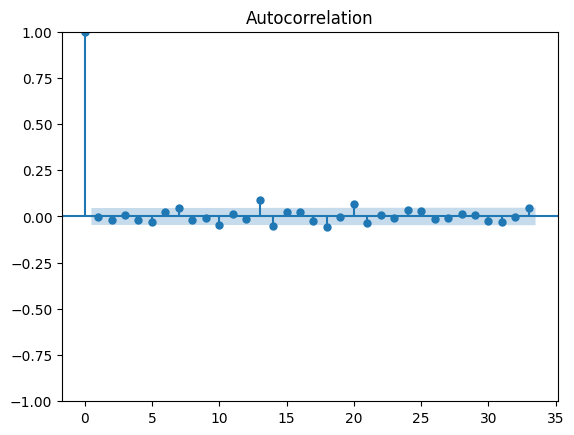

In [30]:
# Ajuster le modèle AR avec l'ordre choisi
p = 1  
model_ar = ARIMA(apple_diff, order=(p, 0, 0))
results_ar = model_ar.fit()

# Afficher le résumé du modèle
print(results_ar.summary())

# Vérifier les résidus
residus_ar = results_ar.resid
plot_acf(residus_ar)
plt.show()

Meilleur modèle ARMA(p,q): p=2, q=4, AIC=7611.081896379616
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1826
Model:                 ARIMA(2, 0, 4)   Log Likelihood               -3797.541
Date:                Sat, 25 Nov 2023   AIC                           7611.082
Time:                        00:48:26   BIC                           7655.161
Sample:                    09-21-2018   HQIC                          7627.341
                         - 09-20-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0675      0.042      1.600      0.110      -0.015       0.150
ar.L1          0.2897      0.035      8.326      0.000       0.221      

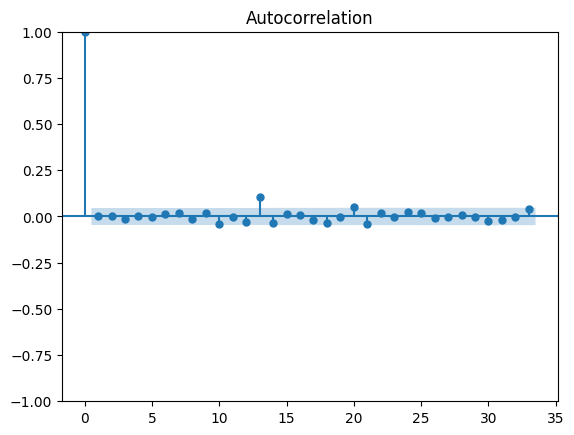

In [31]:
import itertools
# Définir les plages des ordres p et q
p = range(0, 5)  # Exemple : de 0 à 2
q = range(0, 5)  # Exemple : de 0 à 2
pq = itertools.product(p, q)

# Chercher le meilleur modèle ARMA
best_aic = float('inf')
best_order = None
best_model = None

for order in pq:
    try:
        model_temp = ARIMA(apple_diff, order=(order[0], 0, order[1]))
        results_temp = model_temp.fit()
        if results_temp.aic < best_aic:
            best_aic = results_temp.aic
            best_order = order
            best_model = results_temp
    except: 
        continue

# Afficher le meilleur modèle ARMA trouvé
print('Meilleur modèle ARMA(p,q): p={}, q={}, AIC={}'.format(best_order[0], best_order[1], best_aic))

# Afficher le résumé du meilleur modèle ARMA
print(best_model.summary())

# Vérifier les résidus du meilleur modèle
residus_arma = best_model.resid
plot_acf(residus_arma)
plt.show()
